In [3]:
import pandas as pd
import numpy as np
import torch
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import EarlyStoppingCallback
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn

In [4]:
seed_val = 13

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [5]:
TRAIN = True
stemmed = False
data = pd.read_parquet('../../Data/PR_panel.parquet').reset_index()
data = data.sort_values(by = 'date', ascending= True)

if stemmed:
    text = 'text_clean_stemmed'
    result = 'stemmed-pred'
else:
    text = 'text_clean'
    result = 'clean-pred'

X = list(data[text].values)
y = list(data["LRet_12pm_OpenNext"].values)

# X = X[:]
# y = y[:1000]

train_ratio = 0.8
split = int(len(X)*train_ratio)

In [10]:
data.head(1)
len(data[text].values.shape)

1

In [10]:
X[0][:100], data[text][0][:100], data[text].iloc[0][:100],data[text].loc[0][:100]

('ex merix corporation press release merix corporation announces second quarter fiscal results beavert',
 'ex vex unassociated document aep industries inc reports fiscal first quarter results south hackensac',
 'ex merix corporation press release merix corporation announces second quarter fiscal results beavert',
 'ex vex unassociated document aep industries inc reports fiscal first quarter results south hackensac')

In [6]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)
input_tokenized = tokenizer(X, add_special_tokens = True, padding='max_length', truncation=True, max_length=200, return_tensors='pt')


In [7]:
input_tokenized['input_ids'].shape[0]

36750

In [8]:
def data_split(input_tokenized,y, split, batch_size = 16):
    input_ids = input_tokenized['input_ids']
    attention_mask = input_tokenized['attention_mask']
    train_inputs, test_inputs, y_train, y_test = input_ids[:split], input_ids[split:], y[:split], y[split:]
    train_inputs, val_inputs, y_train, y_val = train_test_split(train_inputs, y_train, random_state=13, test_size=0.1) 
    train_masks, test_masks, y_train, y_test = attention_mask[:split], attention_mask[split:], y[:split], y[split:]
    train_masks, val_masks, y_train, y_val = train_test_split(train_masks, y_train, random_state=13, test_size=0.1) 

    # set(y)
    # print('example train_input:', train_inputs[0])
    # print('example attention_mask', train_masks[0])

    train_labels = torch.tensor(y_train).type(torch.FloatTensor)
    validation_labels = torch.tensor(y_val).type(torch.FloatTensor)
    test_labels = torch.tensor(y_test).type(torch.FloatTensor)
    
    # Create the DataLoader for our training set.
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    # Create the DataLoader for our validation set.
    validation_data = TensorDataset(val_inputs, val_masks, validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    return train_dataloader, validation_dataloader, test_dataloader

In [9]:
bert_train_dataloader, bert_validation_dataloader,bert_test_dataloader = data_split(input_tokenized,y, split) #note


In [10]:
for item in bert_test_dataloader:
    token, mask, label = item
    print(token.shape)
    break

torch.Size([16, 200])


In [11]:
class BertRegressor_MLP(BertForSequenceClassification):
    def __init__(self, config):
        super(BertRegressor_MLP, self).__init__(config)
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, 600),
            nn.ReLU(),
            nn.Linear(600, 500),
            nn.ReLU(),
            nn.Linear(500, 400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, self.config.num_labels)
            )

In [12]:
from transformers import AdamW, BertConfig

model_freeze_bert = BertRegressor_MLP.from_pretrained(
    "bert-base-uncased", 
    num_labels = 1, 
    output_attentions = False, 
    output_hidden_states = False,
)
for name, param in model_freeze_bert.named_parameters():
	if 'classifier' not in name: 
		param.requires_grad = False

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertRegressor_MLP: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertRegressor_MLP from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertRegressor_MLP from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertRegressor_MLP were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['

In [13]:


model_finetune_bert = BertRegressor_MLP.from_pretrained(
    "bert-base-uncased", 
    num_labels = 1,    
    output_attentions = False, 
    output_hidden_states = False,
)

RELOAD = False
if RELOAD:
    model_finetune_bert.load_state_dict(torch.load("./" + text+ "-output/finetune/emb-200/pytorch_model.bin"))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertRegressor_MLP: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertRegressor_MLP from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertRegressor_MLP from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertRegressor_MLP were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['

In [15]:
import time
from transformers import get_linear_schedule_with_warmup
import datetime

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))
    
def train_model(model, epochs, train_dataloader, validation_dataloader, device):      
    optimizer = AdamW(model.parameters(),
                  lr = 1e-5, 
                  eps = 1e-8 
                )
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)
    loss_values = []
    eval_accs = []
    model = model.to(device)
    for epoch_i in range(0, epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
        t0 = time.time()

        total_loss = 0
        model.train()

        for step, batch in enumerate(train_dataloader):

            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # This will return the loss (rather than the model output) because we
            # have provided the `labels`.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
            
            # The call to `model` always returns a tuple, so we need to pull the 
            # loss value out of the tuple.
            loss = outputs[0]
            # print("train set")
            # for i in range(outputs[1].shape[0]):
            #     print(outputs[1][i], b_labels[i])
            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)            
        
        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)

        print("")
        print("  Average training loss: {0:.8f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
            

        print("Running Validation...")

        t0 = time.time()
        model.eval()

        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            # batch = tuple(t for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            with torch.no_grad():        
                # Forward pass, calculate logit predictions.
                # This will return the logits rather than the loss because we have
                # not provided labels.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask)
            
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            logits = outputs[0]
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # Calculate the accuracy for this batch of test sentences.
            # for i in range(logits.shape[0]):
            #     print(logits[i], label_ids[i])
            tmp_eval_loss = mean_squared_error(logits, label_ids)
            # Accumulate the total accuracy.
            eval_loss += tmp_eval_loss
            # Track the number of batches
            nb_eval_steps += 1

        avg_eval_acc = eval_loss/nb_eval_steps
        print("  Loss: {0:.8f}".format(avg_eval_acc))
        print("  Validation took: {:}".format(format_time(time.time() - t0)))
        eval_accs.append(avg_eval_acc)
    print("")
    print("Training complete!")
    return loss_values, eval_accs

In [16]:
freeze_bert_loss_vals, freeze_bert_eval_accs = train_model(model_finetune_bert, 300, 
                                    bert_train_dataloader,
                                    bert_validation_dataloader, 'cuda') 


======== Epoch 1 / 300 ========
Training...
  Batch    40  of  1,654.    Elapsed: 0:00:12.
  Batch    80  of  1,654.    Elapsed: 0:00:18.
  Batch   120  of  1,654.    Elapsed: 0:00:24.
  Batch   160  of  1,654.    Elapsed: 0:00:30.
  Batch   200  of  1,654.    Elapsed: 0:00:36.
  Batch   240  of  1,654.    Elapsed: 0:00:41.
  Batch   280  of  1,654.    Elapsed: 0:00:47.
  Batch   320  of  1,654.    Elapsed: 0:00:53.
  Batch   360  of  1,654.    Elapsed: 0:00:59.
  Batch   400  of  1,654.    Elapsed: 0:01:04.
  Batch   440  of  1,654.    Elapsed: 0:01:10.
  Batch   480  of  1,654.    Elapsed: 0:01:15.
  Batch   520  of  1,654.    Elapsed: 0:01:21.
  Batch   560  of  1,654.    Elapsed: 0:01:27.
  Batch   600  of  1,654.    Elapsed: 0:01:32.
  Batch   640  of  1,654.    Elapsed: 0:01:38.
  Batch   680  of  1,654.    Elapsed: 0:01:43.
  Batch   720  of  1,654.    Elapsed: 0:01:49.
  Batch   760  of  1,654.    Elapsed: 0:01:55.
  Batch   800  of  1,654.    Elapsed: 0:02:00.
  Batch   840  

In [17]:
model_path = "./" + text+ "-output/finetune-bert/enb-200"
model_finetune_bert.save_pretrained(model_path)

In [21]:
def predict(model, dataloader, device):
    model.eval()
    model.to(device)
    output = []
    for batch in dataloader:
        batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)
        with torch.no_grad():
            output += [{'pred':model(batch_inputs, 
                            batch_masks)[0].view(-1), 'label': batch_labels}]
    return output

In [185]:
def save_predict_to_df(model, dataloader, device, insmaple = False):
    model.eval()
    model.to(device)
    inputs, labels, pred = [], [], []
    
    for batch in dataloader:
        batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)
        with torch.no_grad():
            b_pred = model(batch_inputs, 
                            batch_masks)[0]
        for i in range(b_pred.shape[0]):
            pred+=b_pred[i].tolist()
            labels+=batch_labels[i].view(-1).tolist()
            tmp = [batch_inputs[i].view(-1).cpu().numpy()]
            inputs+=tmp

    df = pd.DataFrame(list(zip(inputs, labels, pred, [insmaple]*len(inputs))), columns = ['berttoken', 'LRet_12pm_OpenNext', 'pred', 'insample'] )
    return df

In [186]:
test_result = save_predict_to_df(model_finetune_bert, bert_test_dataloader,'cuda', False)
val_result = save_predict_to_df(model_finetune_bert, bert_validation_dataloader,'cuda', False)
train_result = save_predict_to_df(model_finetune_bert, bert_train_dataloader,'cuda', True)


In [391]:
def find_in_df(df, token):
    idx_ = []
    for i in range(len(df)):
        if np.all(df['berttoken'][i] ==  token):
            idx_.append(i)
    ret = df.iloc[idx_][['LRet_12pm_OpenNext']].values[0]
    return ret
# t= tokenizer(txt, add_special_tokens = True, padding='max_length', truncation=True, max_length=100, return_tensors='pt')

In [434]:
pred_results = pd.concat([train_result, val_result, test_result], ignore_index=True)
print('pred dataframe of shape: ',len(pred_results), len(pred_results.columns))
pred_results['LRet_12pm_OpenNext'] = pred_results['LRet_12pm_OpenNext'].round(decimals = 5)
pred_results['LRet_12pm_OpenNext'].values[0]

pred dataframe of shape:  36750 4


0.0008

In [437]:
rounded = np.round(y, decimals=5).tolist()
data_token = pd.DataFrame(zip(X, input_tokenized['input_ids'].numpy(), y, rounded), columns=['text_clean', 'berttoken', 'LRet_12pm_OpenNext', 'rounded_LRet'])
tmp = data_token.merge(data, left_on=['text_clean','LRet_12pm_OpenNext'], right_on=['text_clean','LRet_12pm_OpenNext'] )
tmp.head(1)

,text_clean,berttoken,LRet_12pm_OpenNext,rounded_LRet,PERMNO,date,GVKEY,repdats1,IBES_Act_Date,IBES_Timestamp,...,EffectiveSpread_Percent_DW,PercentRealizedSpread_LR_DW,PercentPriceImpact_LR_DW,QuotedSpread_Percent,prosecuted,prosecuted_new,prosecuted_updated,pr_id,text,text_clean_stemmed
0,ex merix corporation press release merix corpo...,"[101, 4654, 21442, 7646, 3840, 2811, 2713, 214...",0.060138,0.06014,80553,2010-01-04,30247,2010-01-04 00:00:00,2010-01-04 00:00:00,2010-01-04 16:05:00,...,NaN,NaN,NaN,NaN,1,1,1,0,ex merix corporation press release merix corp...,ex merix corpor press releas merix corpor anno...


In [439]:
data_token = tmp
pred_results.berttoken = pred_results.berttoken.apply(tuple)
data_token.berttoken = data_token.berttoken.apply(tuple)
data_pred = data_token.merge(pred_results, left_on=['berttoken','rounded_LRet'], right_on=['berttoken','LRet_12pm_OpenNext'], how = 'left')
print("Merged shape: ",len(data_pred.index),len(data_pred.columns))


Merged shape:  36750 167


In [ ]:
data_pred = data_pred.drop(columns=['LRet_12pm_OpenNext_y', 'rounded_LRet', 'berttoken'])
data_pred[data_pred.pred.isnull()]

In [442]:
data_pred = data_pred.rename(columns={'LRet_12pm_OpenNext_x': 'LRet_12pm_OpenNext', 'pred': 'clean_pred'})
data_pred.columns.difference(data.columns).tolist()

['clean_pred', 'insample']

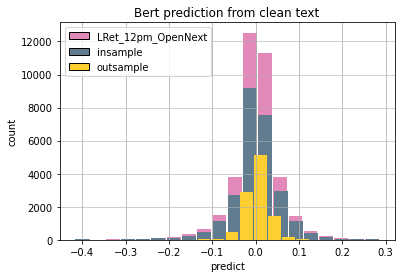

In [459]:
data_pred.LRet_12pm_OpenNext.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#e389b9')
data_pred[data_pred.insample].clean_pred.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
data_pred[data_pred.insample == False].clean_pred.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#ffce30')
from matplotlib.patches import Rectangle
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['#e389b9','#607c8e', '#ffce30']]
labels= ['LRet_12pm_OpenNext',"insample", "outsample"]
plt.legend(handles, labels)
plt.title('Bert prediction from clean text')
plt.xlabel('predict')
plt.ylabel('count')
plt.grid(axis='y', alpha=0.75)

In [ ]:
data_pred[not data_pred.insample].clean_pred.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('out sample prediction from clean text')
plt.xlabel('predict')
plt.ylabel('count')
plt.grid(axis='y', alpha=0.75)

In [ ]:
data_pred = data_pred.sort_values(['PERMNO', 'date']).set_index(['PERMNO', 'date'])

In [450]:
data_pred.head(2)
data_pred.to_parquet('PR_panel_unstem_finetune_pred.parquet')

In [361]:
data_tmp = data[['text_clean', 'LRet_12pm_OpenNext']].sort_values(by='LRet_12pm_OpenNext')
t= tokenizer(data_tmp['text_clean'][10], add_special_tokens = True, padding='max_length', truncation=True, max_length=100, return_tensors='pt')
find_in_df(pred_results,t['input_ids'][0].numpy())[0], data_tmp['LRet_12pm_OpenNext'][10],type(data_tmp['LRet_12pm_OpenNext'][1]),type(find_in_df(pred_results,t['input_ids'][0].numpy())[0])

(-0.01874389313161373, -0.018743892743490864, numpy.float64, numpy.float64)

In [449]:
data_pred[['text_clean', 'clean_pred', 'LRet_12pm_OpenNext', 'insample']]

text_clean  \
PERMNO date                                                            
10025  2010-03-12  ex vex unassociated document aep industries in...   
       2010-06-09  ex vex unassociated document immediate release...   
       2010-09-09  ex vex unassociated document aep industries in...   
       2013-03-12  ex vex aep industries inc reports fiscal first...   
       2013-06-10  ex vex aep industries inc reports fiscal secon...   
...                                                              ...   
93434  2014-05-14  ex exh press release may sw announces results ...   
       2014-11-11  ex exh press release november sw announces res...   
       2015-02-12  ex exh press release february sw announces res...   
       2015-05-14  ex exh press release may sw announces record r...   
       2015-11-12  ex exh press release november sw announces res...   

                   clean_pred  LRet_12pm_OpenNext  insample  
PERMNO date                                                  
10025  2010-03-12    0.108608            0.106196      True  
       2010-06-09    0.030227            0.027792      True  
       2010-09-09    0.017193            0.019967     False  
       2013-03-12    0.013076            0.012601      True  
       2013-06-10   -0.071029           -0.067173      True  
...                       ...                 ...       ...  
93434  2014-05-14    0.074638            0.071507      True  
       2014-11-11    0.016822           -0.002774     False  
       2015-02-12    0.009471            0.010560     False  
       2015-05-14    0.035326            0.143101     False  
       2015-11-12    0.036843            0.036921     False  

[36750 rows x 4 columns]

In [ ]:
predict(model_finetune_bert, bert_test_dataloader, 'cuda')

In [ ]:
params = list(model_finetune_bert.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))
for p in params:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))